# Extracting both the pKa and buridness data

In the following example we will be using TrIPP to determine the p*K*<sub>a</sub> values of the hen egg-white lysozyme (PDB ID: 1AKI). Three replicas have been run (MD1, MD2, and MD3). The files can be found in the tutorial/files folder and contain a PDB file of the minimised structure of the lysozyme and three replicas of the 300 ns trajectory sampled every 100 ps. The files contain only the protein. 

#### The `Trajectory` class 

The main class of TrIPP is the `Trajectory`. It contains the iterator that is able to iterate through the trajectory and extract p*K*<sub>a</sub> values using PROPKA3. The `Trajectory` class requires three arguments: 

- `trajectory_file`: `str`. The path of the file containing the trajectory. The same formats permited by MDAnalysis can be used. 

- `topology_file`: `str`. The path of the file containing the topology. The same formats allowed by MDAnalysis can be used. 

- `cpu_core_number`: `int`, `default=-1`. The number of cpu cores used for the calculation. If cpu_core_number=-1, all available cores are used. 

The `Trajectory` class contains a single method called `run`, which runs the iterator. The `run` method takes the following arguments: 

- `output_file`: `str`. The path of the output CSV file. 

- `extract_surface_data`: `bool`. If `True` both data on buridness and p*K*<sub>a</sub> will be extracted. If `False` only p*K*<sub>a</sub> data will be extracted. 

- `chain`: `str`,`default='A'`. Chain ID of target protein. If no chain ID is found in the `topology_file`, it is set to 'A'. 

- `mutation`: `int` or `list` of `int`, `default=None`. Allows for the *pseudomutation* of residues to alanine. The residue number or list of residue numbers is provided and TrIPP is run on the trajectory with the side chains of the selected residues removed and the residues treated as alanine. By comparing the *pseudomutated* trajectory to the unchanged, it is possible to understand the coontributions of the *pseudomutated* residues to the p*K*<sub>a</sub> of interacting residues. 

- `disulphide_bond_detection`: `bool`, `default=True`. If `True` detects all disulphide bonds present in the topology file and does not provide p*K*<sub>a</sub> values for them. 


Running the calculation produces a CSV file for each trajectory containing the p*K*<sub>a</sub> values (named 'output_file'_pka.csv) and one containing the buridness data (named 'output_file'_surf.csv), where each row corresponds to a timestep and each column to a residue. 

In [3]:
from tripp import Trajectory

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output' 

topology_file = f'{file_directory}/1AKI_minstr.pdb' #topology, can be any format readable by MDAnalysis

for md in range(1,4): 
    trajectory_file = f'{file_directory}/1AKI_md{md}_300ns.xtc' #trajectory, can be any format readable by MDAnalysis
    TrIPP_Traj = Trajectory(trajectory_file=trajectory_file, 
                            topology_file=topology_file, 
                            cpu_core_number=-1) #Setting the argument cpu_number to -1 allows for the use of all available CPUs 
    
    TrIPP_Traj.run(output_file = f'{output_directory}/1AKI_md{md}', 
                   extract_surface_data=True, #If this is set to False, only pKa data will be extracted, else both pKa and buridness data will be extracted 
                   chain='A', 
                   mutation=None, 
                   disulphide_bond_detection=True) #Automatically detects disulphide bonds and removes the cysteines from pKa calculation 

Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS

It is often the case that the deviation of the p*K*<sub>a</sub> value of a residue in a protein from its model value in solution is important. It is affected by interactions with the environments (electrostatic, hydrogen bonding, apolar etc). TrIPP offers a function to determine the deviation for every residue compared to its model value during the trajectory. 

After calculating the p*K*<sub>a</sub> values of the protein residues using the `Trajectory.run()` method, it is possible to use the `process.calculate_difference_to_model()` function to calculate the difference to the model value for each residue. It takes a sinlge input: 

- `output_file`: `str`, must be the same `output_file` used in the `Trajectory.run()` method. 

This function produces a CSV file for each trajectory in the same directory as the original p*K*<sub>a</sub> file named 'output_file'_difference_to_model.csv. 

In [4]:
from tripp.process import calculate_difference_to_model 

output_directory = 'tutorial/output' 

for md in range(1,4): 
    calculate_difference_to_model(output_file=f'{output_directory}/1AKI_md{md}') 

Once the p*K*<sub>a</sub> values and differences to model values are calculated for the trajectory, their distribution can be visualised. This allows us to determine, which residues are more likely to change protonation state and diverge the most from model values. 

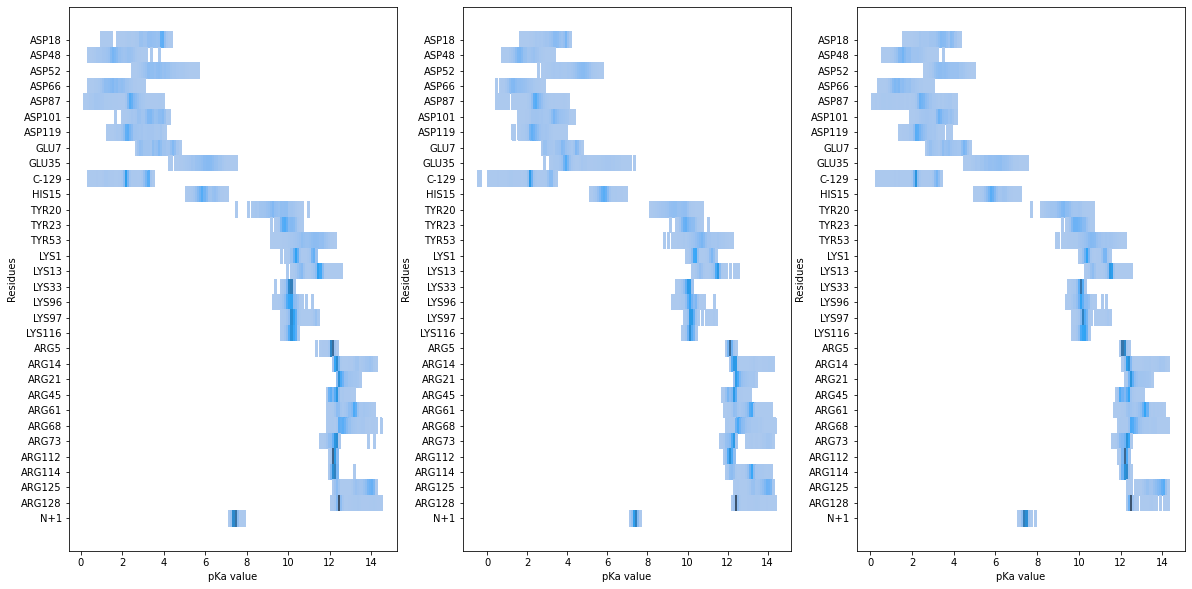

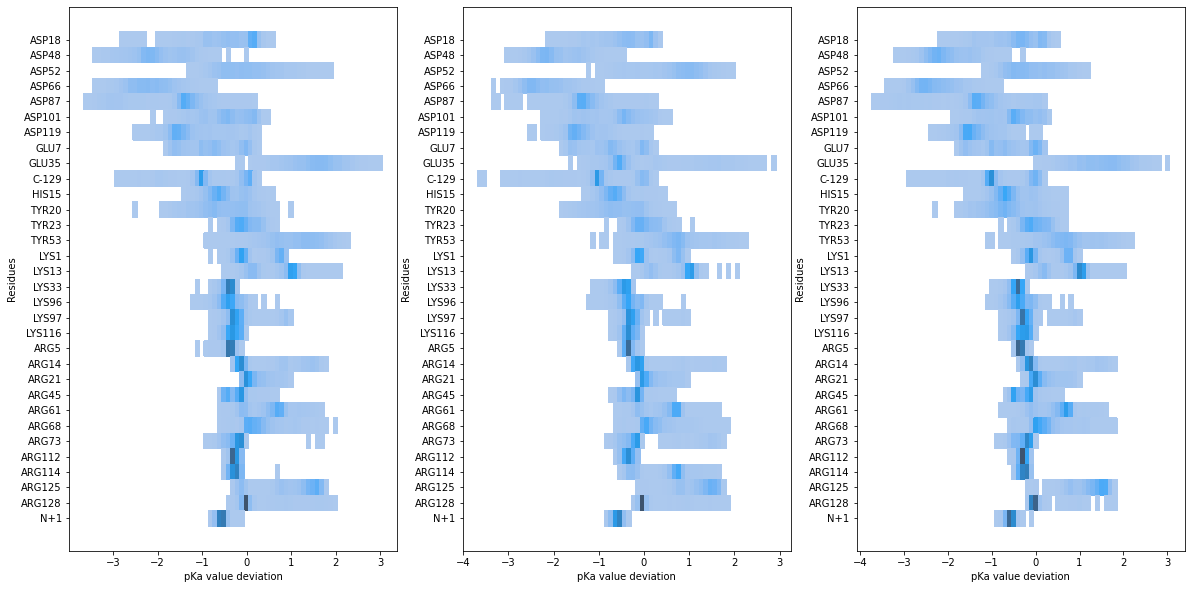

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

fig, ax = plt.subplots(1,3, figsize=(20, 10)) 

#Plot histogram showing the pKa values ls
for md in range(1,4): 
    df_md = pd.read_csv(f'{output_directory}/1AKI_md{md}_pka.csv') 
    df_melt = df_md.melt(id_vars='Time [ps]', var_name='Residues', value_name='pKa value') 
    sns.histplot(data=df_melt, x='pKa value', y='Residues', ax=ax[md-1], binwidth=0.1) 

fig, ax = plt.subplots(1,3, figsize=(20, 10)) 

#Plot histogram showing the deviation from the model pKa values 
for md in range(1,4): 
    df_md = pd.read_csv(f'{output_directory}/1AKI_md{md}_difference_to_model.csv') 
    df_melt = df_md.melt(id_vars='Time [ps]', var_name='Residues', value_name='pKa value deviation') 
    sns.histplot(data=df_melt, x='pKa value deviation', y='Residues', ax=ax[md-1], binwidth=0.1) 

The above figure shows the distribution of the p*K*<sub>a</sub> value deviation for the three replicas. 

The acidic residues ASP52 and GLU35 are of particular interest since they show an upshift of their p*K*<sub>a</sub> values. The model p*K*<sub>a</sub> values for aspartate and glutamate residues are 3.8 and 4.5, respectively. An increase of their p*K*<sub>a</sub>, due to their location in the protein, would allow for their protonation. Furthermore, these two residues are involved in the catalytic site of the henn egg-white lysozyme and are in proximity to one another. 

<center> 

|Residue|Bartik _et al._|Webb _et al._|PROPKA3|MD1|MD2|MD3
:------:|:-------------:|:-----------:|:-----:|:---:|:---:|:---:
N-term|-|-|7.41|7.45±0.07|7.43±0.08|7.44±0.06
LYS1|-|-|11.26|10.7±0.43|10.66±0.4|10.69±0.42
ARG5|-|-|12.20|12.14±0.07|12.17±0.06|12.16±0.05
GLU7|2.85±0.25|2.6±0.2|3.49|3.76±0.56|3.82±0.55|3.89±0.58
LYS13|-|-|10.64|11.25±0.43|11.35±0.36|11.36±0.35
ARG14|-|-|12.31|12.73±0.61|12.48±0.37|12.59±0.51
HIS15|5.36±0.07|5.5±0.2|6.40|5.99±0.32|5.85±0.23|5.91±0.29
ASP18|2.66±0.08|2.8±0.3|3.17|3.54±0.5|3.45±0.45|3.43±0.47
TYR20|-|-|9.25|9.44±0.49|9.43±0.45|9.31±0.42
ARG21|-|-|12.84|12.67±0.24|12.65±0.25|12.66±0.26
TYR23|-|-|9.89|9.98±0.22|10.04±0.22|10.01±0.23
LYS33|-|-|10.17|10.11±0.09|10.06±0.12|10.1±0.09
GLU35|6.20±0.10|6.1±0.4|5.55|6.06±0.47|4.42±0.9|6.0±0.49
ARG45|-|-|12.09|12.27±0.18|12.3±0.17|12.24±0.18
ASP48|<2.5|1.4±0.2|1.55|1.77±0.48|1.85±0.4|1.75±0.39
TYR53|-|-|11.65|11.13±0.52|10.79±0.48|10.75±0.5
ASP52|3.68±0.08|3.6±0.3|3.28|3.8±0.52|4.56±0.55|3.7±0.45
ARG61|-|-|13.33|13.06±0.43|12.97±0.36|13.03±0.35
ASP66|<2.0|1.2±0.2|-|1.64±0.4|1.58±0.38|1.51±0.37
ARG68|-|-|12.62|12.79±0.34|12.74±0.31|12.73±0.32
ARG73|-|-|12.29|12.27±0.15|12.48±0.59|12.25±0.14
ASP87|2.07±0.15|2.2±0.1|2.43|2.26±0.71|2.55±0.34|2.51±0.67
LYS96|-|-|10.10|10.12±0.18|10.21±0.18|10.16±0.2
LYS97|-|-|10.17|10.35±0.34|10.26±0.17|10.28±0.22
ASP101|4.09±0.07|4.5±0.1|4.09|3.41±0.46|3.24±0.52|3.35±0.42
ARG112|-|-|12.24|12.24±0.06|12.17±0.1|12.23±0.06
ARG114|-|-|12.23|12.25±0.08|13.01±0.5|12.25±0.08
LYS116|-|-|10.27|10.2±0.13|10.19±0.11|10.23±0.13
ASP119|3.20±0.09|3.5±0.3|2.87|2.55±0.51|2.43±0.32|2.41±0.3
ARG125|-|-|13.48|13.62±0.61|13.81±0.34|13.83±0.31
ARG128|-|-|12.42|12.6±0.39|12.52±0.25|12.5±0.17
C-term|2.75±0.02|2.7±0.2/3.9±0.1|3.21|2.55±0.61|2.43±0.57|2.5±0.54

</center>



# Visualization 

TrIPP also offers the ability to visualise p*K*<sub>a</sub> values on the structure of the protein. This is done by using the `Visualization` class. 

The `Visualization` class takes two arguments: 

- `structure`: `str`. The file path of the structure that is going to be used for visualisation. 

- `pka_file`: `str` or `list`. The file path or a list of file paths of the CSV file containing the p*K*<sub>a</sub> to visualise. 


The `Visualisation` class contains the method `color_pka`, which is called to generate a PDB file containing the p*K*<sub>a</sub> values in the B-factor column and a PyMOL session file. 

- `pymol_path`: `str`. Path to the PyMOL software binary needs to be specified. The script will spawn a subprocess shell to run a python script in PyMOL. 

- `output`: `str`. Path to output file. The name of the ouput file will be extended depending on the `coloring_method` argument. 

- `coloring_method`: `'mean'`,`'difference_to_model_value'`, `int`, or `float`, `default='mean'`. Type of method used to assign p*K*<sub>a</sub> values to each residue. 

    - If `'mean'`, the mean of all p*K*<sub>a</sub> values in the `pka_file` for all residues is used. 

    - If `'difference_to_model_value'`, the mean difference of all p*K*<sub>a</sub> values in the `pka_file` to the model value of the amino acid in solution is used. 
    
    - If `int` or `float`, a specific timestep is selected for visualisation. 

- `lower limit`: `int` or `float`, `default=0`. Lower limit used to colour the residues in the PyMOL session. Any value below the limit is coloured using the lowest end of the color gradient used. 

- `upper limit`: `int` or `float`, `default=14`. Upper limit used to colour the residues in the PyMOL session. Any value above the limit is coloured using the highest end of the color gradient used. 

- `color_palette`: `str`, `default='red_white_blue'`. Colour palettes used to colour the residues in the PyMOL session according to the p*K*<sub>a</sub> value. The default is set to `'red_white_blue'`. See [PyMOL spectrum](https://pymolwiki.org/index.php/Spectrum) for allowed color palettes. Three colors palette is suggested. 


We will use all three p*K*<sub>a</sub> files generated for trajectories MD1, MD2, and MD3 to visualise the mean p*K*<sub>a</sub> value of the residues mapped onto the initial minimised structure of HEWL. 

In [6]:
from tripp import Visualization

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output' 

topology_file = f'{file_directory}/1AKI_minstr.pdb' 
pymol_path = '/usr/local/Cellar/pymol/2.5.0/bin/pymol' #Make sure you specify where your pymol installation is 
pka_files = [f'{output_directory}/1AKI_md1_pka.csv', f'{output_directory}/1AKI_md2_pka.csv', f'{output_directory}/1AKI_md3_pka.csv'] #make a lsit of all pka files to be included in the calculation of the mean pka values 

TrIPP_Vis = Visualization(structure=topology_file, 
                          pka_file=pka_files) 

TrIPP_Vis.color_pka(pymol_path=pymol_path, 
                    output=f'{output_directory}/1AKI_all_md_pka', 
                    coloring_method='mean', 
                    lower_limit=0, 
                    upper_limit=14, 
                    color_palette='red_white_blue') 


Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default


The PyMOL session file contains a visualisation of the protein in cartoon representation. The residues that have p*K*<sub>a</sub> associated with them are colored according to the colour palette specified in the `color_pka` method. The mean p*K*<sub>a</sub> values are shown as labels next to the residues. ![overview](./tutorial/files/overview.png)

A closer look at the residues ASP52 and GLU35 shows that they are close together and have mean p*K*<sub>a</sub> values of 4.5 and 5 ![closeup](tutorial/files/closeup.png) 

We can also visualise the difference to the model value. 

In [7]:
TrIPP_Vis = Visualization(structure=topology_file, 
                          pka_file=pka_files) 

TrIPP_Vis.color_pka(pymol_path=pymol_path, 
                    output=f'{output_directory}/1AKI_all_md_pka', 
                    coloring_method='difference_to_model_value', 
                    lower_limit=0, 
                    upper_limit=14, 
                    color_palette='red_white_blue') 

Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default


# Clustering trajectories based on p*K*<sub>a</sub> values 

Visualising the p*K*<sub>a</sub> values of the two residues allows us to see the relationship between the two values. 

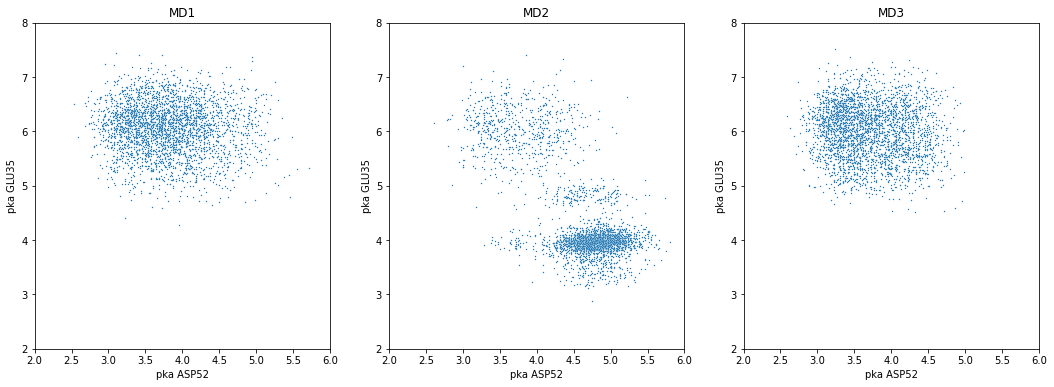

In [8]:
fig, ax = plt.subplots(1,3, figsize=(18,6)) 

for md in range(1,4): 
    df_md = pd.read_csv(f'{output_directory}/1AKI_md{md}_pka.csv') 
    sns.scatterplot(data=df_md, x='ASP52', y='GLU35', ax=ax[md-1], s=2) 
    ax[md-1].set_xlim(2,6) 
    ax[md-1].set_ylim(2,8) 
    ax[md-1].set_xlabel('pka ASP52') 
    ax[md-1].set_ylabel('pka GLU35') 
    ax[md-1].set_title(f'MD{md}') 

The scatterplot of the p*K*<sub>a</sub> values of GLU35 and ASP52 shows two distinct populations of points. In MD1 and MD3 the p*K*<sub>a</sub> of GLU35 are higher compared to those of ASP52. In MD2 the same relationship is only observed for a subset of frames. In the rest of the MD2 frames the relationship seems to be inverted. 

The second class of TrIPP is the `Clustering` class. It allows for the clustering of trajectory frames using the p*K*<sub>a</sub> values of selected residues alongside charge center distances (if selected). 

The `Clustering` takes the following arguments: 

- `trajectory_file`: `str` or `dict`. When `str`, it is the path of the file containing the trajectory. The same formats permited by MDAnalysis can be used. When `dict`, the clustering is done using multiple trajectories specified in a dictionary, where the name of each trajectory is used as a key and the path as an object: {'MD1' : 'file1', 'MD2' : 'file2', ...}. The same topology file is used for all trajectories. 

- `topology_file`: `str`. Path to the topology file. The same formats allowed by MDAnalysis can be used. 

- `pka_file`: `str` or `list`. When `str`, it is the path of the CSV file containing the p*K*<sub>a</sub> values generated by the `Trajectory` class using the same trajectory file and topology file selected for the clustering. When `list`, it is a list of paths of the CSV files corresponding to the dictionary selected for `trajectory_file`. When selecting a list of files for the `pka_file` argument the order of the files needs to be the same as in the `trajectory_file` dictionary. 

- `residues`: `list`. List of residues for which the clustering will be done. The residues have a p*K*<sub>a</sub> value assigned to them by PROPKA. 

- `log_file`: `str`. File name for log file 

- `surf_file`: `str` or `list`. When `str`, it is the path of the CSV file containing the buriedness measurements generated by the `Trajectory` class using the same trajectory file and topology file selected for the clustering. When `list`, it is a list of paths of the CSV files corresponding to the dictionary selected for `trajectory_file`. When selecting a list of files for the `surf_file` argument the order of the files needs to be the same as in the `trajectory_file` dictionary. 

- `include_distances`: `bool`, `default=False`. If `True`, the relative positions (as distances between the charge centers) are used as additional features for the clustering. 

- `include_buriedness`: `bool`, `default=False`. If `True`, the buriedness measurements are used as additional features for the clustering. 

- `dimensionality_reduction`: `bool`, `default=False`. If `True`, dimensionality reduction is performed on the generated data (p*K*<sub>a</sub> values and if selected charge center distances) using PCA. The number of components is selected that described >=90% of the cummulative variance and the clustering is done on those components. 

The `Clustering` contains three methods corresponding to three different clustering algorithms: `kmedoids`, `gromos`, and `dbscan`. The choice of clustering algorithm depends on the data the clustering is done on. In this case, we will be using the `kmedoids` method. It takes the following arguments: 

- `automatic`: `bool`, `default=False`. If `True` the clustering is run using various cluster numbers (defined by `max_clusters`). The silhouette score is determined at each iteration and the best number of clusters is chosen based on the highest silhouette score. 

- `n_clusters`: `int`, `default=8`. Number of clusters used for the clustering. Ignored if `automatic=True`. 

- `metric`, `method`, `init`, `max_iter`, `random_state` as found in [sklearn_extra.cluster.KMedoids](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html). 

- `max_clusters`: `int`, `default=20`. Max number of clusters to use when `automatic=True`. 

In our example, we will initially cluster all three trajectories and settting `automatic=True`. The clustering will generate PDB structures corresponding to the cluster centroid. 

In [3]:
from tripp import Clustering 

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output' 

topology_file = f'{file_directory}/1AKI_minstr.pdb' 

trajectory_files = {'MD1' : f'{file_directory}/1AKI_md1_300ns.xtc', 
                    'MD2' : f'{file_directory}/1AKI_md2_300ns.xtc', 
                    'MD3' : f'{file_directory}/1AKI_md3_300ns.xtc'} 

pka_files = [f'{output_directory}/1AKI_md1_pka.csv', 
             f'{output_directory}/1AKI_md2_pka.csv', 
             f'{output_directory}/1AKI_md3_pka.csv'] 

TrIPP_Clust = Clustering(trajectory_file=trajectory_files, 
                         topology_file=topology_file, 
                         pka_file=pka_files, 
                         surf_file=None, 
                         residues=[35, 52], 
                         log_file=f'{output_directory}/1AKI_all_md', 
                         include_distances=False, 
                         include_buriedness=False,
                         dimensionality_reduction=False) 

TrIPP_Clust.kmedoids(automatic=True, 
                     max_clusters=20) 

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Clustering with 2 clusters produces an average silhouette score of 0.6377.
Clustering with 3 clusters produces an average silhouette score of 0.3928.
Clustering with 4 clusters produces an average silhouette score of 0.3902.
Clustering with 5 clusters produces an average silhouette score of 0.3796.
Clustering with 6 clusters produces an average silhouette score of 0.3624.
Cluster

The clustering produces a log file containing the clustering details (1AKI_clean_all_md_KMedoids.log), one PDB file for each cluster containing the cluster centroid structure (1AKI_clean_all_md_C0.pdb and 1AKI_clean_all_md_C1.pdb) and one CSV file containing the clustering data alongside the p*K*<sub>a</sub> values (1AKI_clean_all_md_cluster.csv). Visualising the clustering results allows use to determine the quality of the clustering.  

<AxesSubplot:xlabel='ASP52', ylabel='GLU35'>

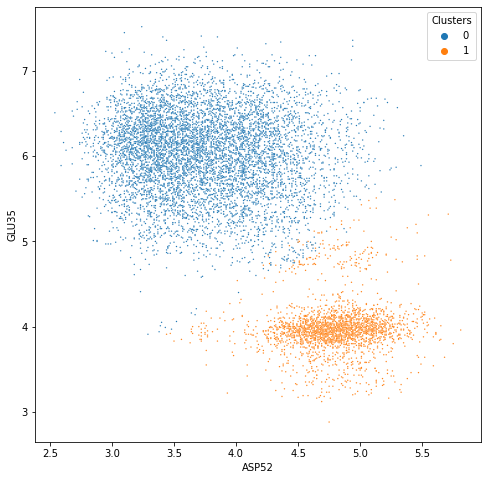

In [5]:
fig = plt.subplots(figsize=(8,8)) 

df_cluster = pd.read_csv(f'{output_directory}/1AKI_all_md_cluster.csv') 
sns.scatterplot(data=df_cluster, x='ASP52', y='GLU35', s=2, hue='Clusters', palette='tab10') 

The cluster centroids of the two clusters indicate that the residue ARG114 might be interacting with GLU35, which might be affecting the glutamates p*K*<sub>a</sub> values. To further refine the clustering it can be rerun by taking into consideration the p*K*<sub>a</sub> values of ARG114. The distances between the charge centres of the residues can also be taken into consideration by setting `include_distances=True`. This will allow to take into consideration the relative position of the residues alogside the p*K*<sub>a</sub>. The buriedness measurements of PROPKA3, which were extracted using the `Trajectory` class can also be used by specifying the generated CSV files using the `surf_file` argument and setting the argument `include_buriedness=True`. 

There are nine features selected for the clustering (three p*K*<sub>a</sub> values, three distances, and three buriedness measures) for each frame. To counter the potential loss of clustering quality, dimensionality reduction can be used by setting `dimensionality_reduction=True`. When this argument is set to `True`, PCA is run on the dataset and the least amount of principal components that describe 90% of the cummulative variance are selected. The clustering is run on the data projected onto those PCs. 

Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Clustering with 2 clusters produces an average silhouette score of 0.728.
Clustering with 3 clusters produces an average silhouette score of 0.4957.
Clustering with 4 clusters produces an average silhouette score of 0.4722.
Clustering with 5 clusters produces an average silhouette score of 0.4506.
Clustering with 6 clusters produces an average silhouette score of 0.4435.
Clusteri

<AxesSubplot:xlabel='ASP52', ylabel='GLU35'>

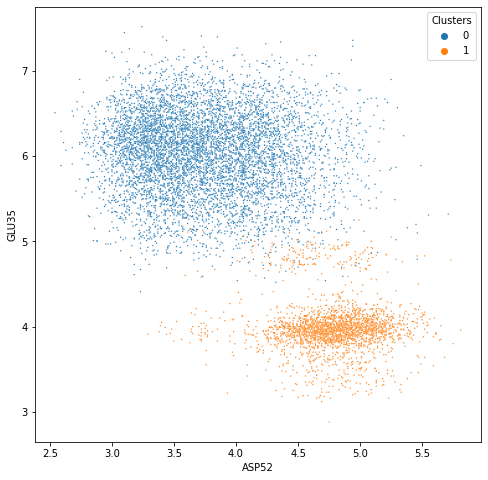

In [6]:
from tripp import Clustering 

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output' 

topology_file = f'{file_directory}/1AKI_minstr.pdb' 

trajectory_files = {'MD1' : f'{file_directory}/1AKI_md1_300ns.xtc', 
                    'MD2' : f'{file_directory}/1AKI_md2_300ns.xtc', 
                    'MD3' : f'{file_directory}/1AKI_md3_300ns.xtc'} 

pka_files = [f'{output_directory}/1AKI_md1_pka.csv', 
             f'{output_directory}/1AKI_md2_pka.csv', 
             f'{output_directory}/1AKI_md3_pka.csv'] 

surf_files = [f'{output_directory}/1AKI_md1_surf.csv', 
              f'{output_directory}/1AKI_md2_surf.csv', 
              f'{output_directory}/1AKI_md3_surf.csv'] 

TrIPP_Clust = Clustering(trajectory_file=trajectory_files, 
                         topology_file=topology_file, 
                         pka_file=pka_files, 
                         residues=[35, 52, 114], 
                         log_file=f'{output_directory}/1AKI_all_md_35_52_114_include_distances_buriedness', 
                         surf_file=surf_files, 
                         include_distances=True, 
                         include_buriedness=True, 
                         dimensionality_reduction=True) 

TrIPP_Clust.kmedoids(automatic=True, 
                     max_clusters=20) 

fig = plt.figure(figsize=(8,8)) 

df_cluster = pd.read_csv(f'{output_directory}/1AKI_all_md_35_52_114_include_distances_buriedness_cluster.csv') 
sns.scatterplot(data=df_cluster, x='ASP52', y='GLU35', s=2, hue='Clusters', palette='tab10') 

The new cluster representatives show that in cluster 0 ASP52 is forming hydrogen bonds with ASN44 and GLU35 is not in interacting distance with ARG114. In cluster 1, the hydrogen bonds between ASP52 and ASN44 are lost and GLU35 is forming a salt bridge with ARG114. As a next step it would be interesting to understand the contibution of these interactions to the p*K*<sub>a</sub> during the trajeectory. To do this, TrIPP offers the _pseudomutation_ capability. 

# _Pseudomutations_ in TrIPP 

TrIPP offers a built-in way to understand the contribution of interactions to the p*K*<sub>a</sub> of a residue. The way TrIPP does this is by running the p*K*<sub>a</sub> iterator of the `Trajectory` class and setting the `mutation` argument to the residue of interest. This leads to TrIPP running the p*K*<sub>a</sub> calculations on the trajectory, however, with the residue of choice being changed to alanine. This does not affect the conformation of the trajectory in any way since no new MD simulations are run. It allows for the determination of the p*K*<sub>a</sub> of residues in teh absence of the functional group contributions of the selected residues. 

In our example, we will run three _pseudomutations_: One where ASN44 is mutated, one where ARG114 is mutated, and one where both are. 

In [7]:
from tripp import Trajectory 

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output' 

topology_file = f'{file_directory}/1AKI_minstr.pdb' 

for md in range(1,4): 
    for mutation in [44, 114, [44, 114]]: 
        trajectory_file = f'{file_directory}/1AKI_md{md}_300ns.xtc' 
        TrIPP_Traj = Trajectory(trajectory_file=trajectory_file, 
                                topology_file=topology_file, 
                                cpu_core_number=-1) 
        TrIPP_Traj.run(output_file=f'{output_directory}/1AKI_md{md}', 
                       extract_surface_data=False, 
                       chain='A', 
                       mutation=mutation, 
                       disulphide_bond_detection=True) 

Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no formal charges. Will set formal charges to 0 for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS

Visualising the the p*K*<sub>a</sub> values of GLU35 and ASP52 for the different pseudomutations and trajectories allows us to see the contributions of ASN44 and ARG114. 

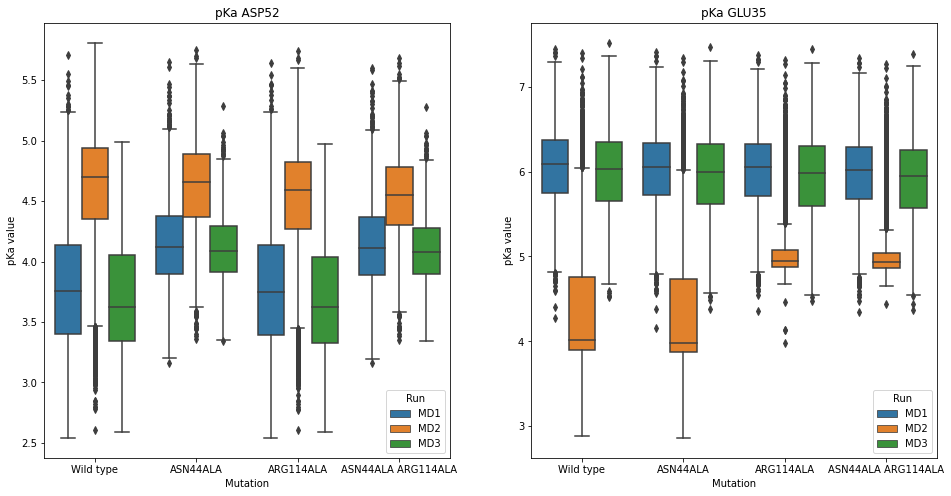

In [8]:
mutant_df_list = [] 
mutation_dict = {'Wild type' : '', 'ASN44ALA' : '_44', 'ARG114ALA' : '_114', 'ASN44ALA ARG114ALA' : '_44_114'} 
for md in range(1,4): 
    for index, mutation in enumerate(mutation_dict.keys()): 
        df = pd.read_csv(f'{output_directory}/1AKI_md{md}{mutation_dict[mutation]}_pka.csv') 
        df = df[['Time [ps]', 'ASP52', 'GLU35']] 
        df_melt = df.melt(id_vars='Time [ps]', var_name='Residues', value_name='pKa value') 
        df_melt['Run'] = f'MD{md}' 
        df_melt['Mutation'] = mutation 
        mutant_df_list.append(df_melt) 

df_mutant = pd.concat(mutant_df_list) 

fig, ax = plt.subplots(1,2, figsize=(16,8)) 
for index, item in enumerate(['ASP52', 'GLU35']): 
    sns.boxplot(data=df_mutant[df_mutant['Residues']==item], x='Mutation', y='pKa value', hue='Run', ax=ax[index]) 
    ax[index].set_title(f'pKa {item}') 